## sounds pretreatment

In [147]:
wave_file = r"./datas/A2_0.wav"

In [148]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np

In [149]:
sampling_freq , audio = wavfile.read(wave_file) # 读出采样率和时域数据矩阵

In [150]:
print(sampling_freq,audio)

16000 [-296 -424 -392 ... -394 -379 -390]


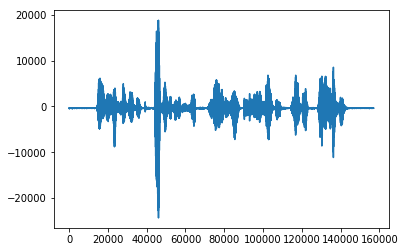

In [197]:
def plot_sound(audio):
    x_ = np.arange(0,len(audio))
    plt.plot(x_,audio)
    plt.show()
    
def scat_array(array):
    x_ = np.arange(0,len(array))
    plt.scatter(x_,array)
    plt.show()
plot_sound(audio)

In [152]:
import sounddevice as sd

In [153]:
def play_sound(sound_array,freq):
    """
    play a sound 
    """
    sd.play(sound_array,sampling_freq)

### 预加重  pre-emphasis

In [154]:
def pre_emphasis(sound_array,u):
    """
    u:预加重系数  coefficient
    """
    temp = np.append(sound_array[0], sound_array[1:] - u * sound_array[:-1])
    print(temp)
    return temp

[-296.   -133.92   23.52 ...   -9.84    7.12  -18.58]


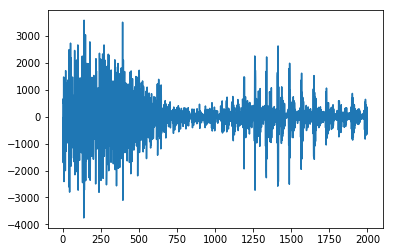

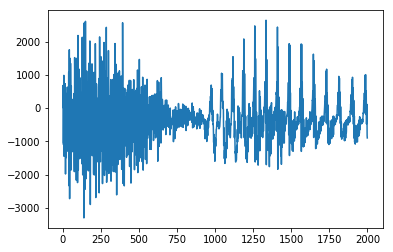

In [155]:
pre_emphasised = pre_emphasis(audio,0.98)
plot_sound(pre_emphasised[20000:22000])
plot_sound(audio[20000:22000])

In [156]:
play_sound(pre_emphasised,16000)

#### 作用
* 增强高频能量，提升高频分辨率，衰弱200HZ以下的频率成分

#### 问题
* 预加重后，反而噪音变强了

#### 发现
* 预加重后，时域波形图明显变“密”了（高音部分变多了，所以直观地听起来就是更嘈杂了）
* 频率越高声音越尖，频率越低声音越低沉
* 明显听后者声音更加低沉

#### 个人理解
* 虽然噪声变大了，但是发现预处理后，整个音频都充斥着这个噪声，在计算机看来，这个噪声其实可以理解成“没有噪声”（只是相对的）

### 分帧加窗

In [157]:
import scipy.signal as signal

In [158]:
#分帧、加窗
def enframe(signal,nw,inc,window_func=None):
    """
    signal:原始信号
    nw:帧长
    inc:相邻帧间隔,步长
    window_func:窗函数
    """
    signal_length = len(signal)
    if signal_length < nw:
        # nf为帧的数量
        nf = 1
    else:
        # np.ceil 计算大于该值的最小整数
        nf = int(np.ceil((1.0*signal_length-nw+inc)/inc))
    pad_length = int((nf-1)*inc+nw) #所有帧的帧长之和
    zeros = np.zeros((pad_length-signal_length,)) # 补0
    pad_signal = np.concatenate((signal,zeros))
    indices = np.tile(np.arange(0,nw),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(nw,1)).T
    indices = np.array(indices,dtype=np.int32)
    frames = pad_signal[indices]
    if window_func is not None:
        win = np.tile(window_func,(nf,1))
        return frames*win
    return frames

In [159]:
frames = enframe(pre_emphasised,512,256)
print(frames)

[[-296.   -133.92   23.52 ...  -27.96  -26.38   -4.76]
 [  -8.    -14.      1.88 ...   -8.24   -1.26  -14.14]
 [  15.3    -2.24   -5.14 ...    6.14  -11.58  -24.66]
 ...
 [  -9.2    11.78  -29.82 ...  -10.1     2.84  -13.96]
 [ -30.48    9.06   -0.6  ...    5.5   -11.24    2.68]
 [ -25.1   -12.46    4.44 ...    0.      0.      0.  ]]


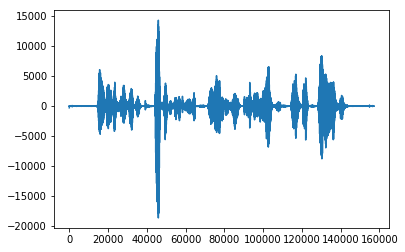

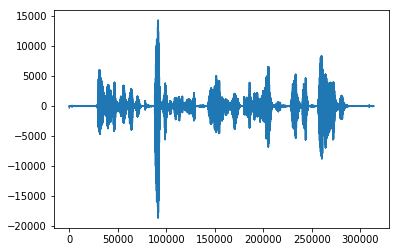

In [160]:
plot_sound(pre_emphasised)
plot_sound(frames.flatten())
play_sound(frames.flatten(),len(frames.flatten()))

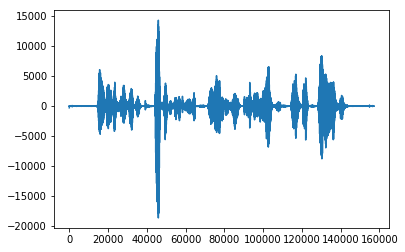

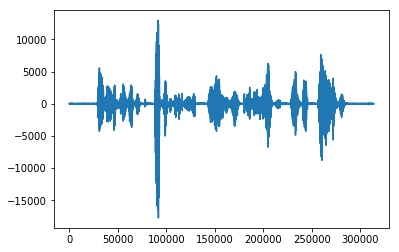

In [161]:
hanning_frames = enframe(pre_emphasised,512,256,signal.hanning(512))
plot_sound(pre_emphasised)
plot_sound(hanning_frames.flatten())
play_sound(hanning_frames.flatten(),len(hanning_frames.flatten()))

#### 作用
* 语音信号本是一种典型的非平稳信号，但是相对于声波振动的速度，发音器官的运动就是非常缓慢的了，所以工程上通常认为10-30ms这样长度的时间段中，语音信号是平稳的

#### 问题
* 无

#### 发现
* 整体音频变长了，说话变缓了,毕竟有叠音。
* 未加窗的有明显的拖长和重声的现象
* 加了hanning窗后，重声现象有效减缓

#### 个人理解
* 整体作用如上所述，这样变换后，让音频更像“图像”了。但是比图像的像素更具连续性的特点
* hanning窗，保留中间部分，消弱边缘部分，能够有效抑制重音现象

### 短时能量

In [162]:
#短时能量
def cal_energy(frames):
    energy = []
    for frame in frames:
        sum = 0 
        for i in frame:
            sum += i**2
        energy.append(sum)
    return energy

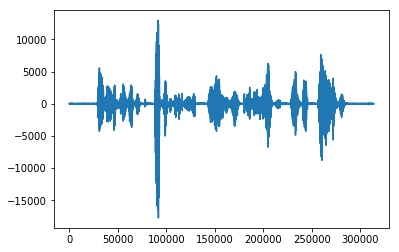

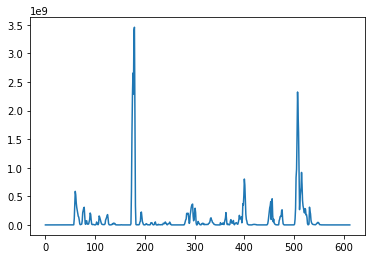

In [163]:
plot_sound(hanning_frames.flatten())
plot_sound(cal_energy(hanning_frames))

#### 作用
* 代表语音帧的能量大小，可以用来检测端点

#### 问题
* 无

#### 发现
* 能够看出能量的聚集点，明显“大”字（180帧左右）这块能量最高

#### 个人理解
* 能够反应轻重音和快慢音的特征。

### 短时平均幅度

In [164]:
# 短时平均幅度
def cal_amplitude(frames):
    energy = []
    for frame in frames:
        sum = 0 
        for i in frame:
            sum += abs(i)
        energy.append(sum)
    return energy

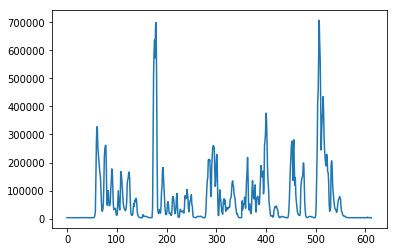

In [165]:
plot_sound(cal_amplitude(hanning_frames))

#### 作用
* 代表语音帧的能量大小，可以用来检测端点等

#### 问题
* 无

#### 发现
* 明显幅度差变低，更“像”原音频

#### 个人理解
* 对于高音不那么敏感。

### 短时过零率

In [166]:
def sgn(data):
    if data >= 0:
        return 1
    else:
        return -1
def cal_crossing_zero_rate(frames):
    zero_cross = []
    for frame in frames:
        sum = 0
        for i in range(len(frame)):
            sum += abs(sgn(frame[i])-sgn(frame[i-1]))
        sum = 0.5 * sum
        zero_cross.append(sum)
    return zero_cross

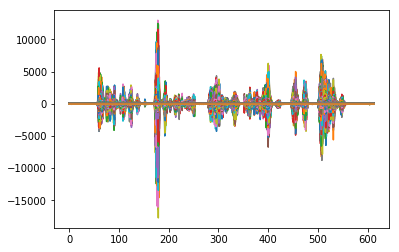

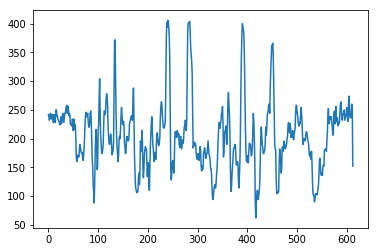

In [167]:
plot_sound(hanning_frames)
plot_sound(cal_crossing_zero_rate(hanning_frames))


#### 作用
* 过零率越大证明该帧频率越大,清音段多数在高频率上，平均过零率大，而浊音较小

#### 问题
* 无

#### 发现
* 较乱，暂无发现

#### 个人理解
* 无

### 短时自相关函数

In [206]:
def self_correlation(frames,K=0):
    self_corr = []
    if K == 0 :
        # K默认是帧长
        K = len(frames[0])
    for frame in frames:
        Rm = np.zeros((K,1))
        for k in range(1,K):
            for i in range(len(frame)-k):
                Rm[k] += frame[i] * frame[i+k]
#             self_corr.append(sum)
        self_corr.append(Rm)
    return self_corr 

In [207]:
# self_corr = self_correlation(hanning_frames)

In [212]:
# print(np.shape(self_corr))

(613, 512, 1)


In [221]:
def get_f0_corr(self_corr):
    f_0s = []
    for frame in self_corr:
        f_0s.append(np.argmax(frame))
    return f_0s

In [213]:
# f0 = get_f0(self_corr)

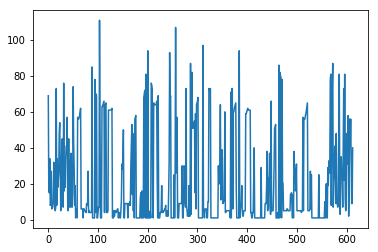

In [215]:
# plot_sound(f0)

#### 作用
* 能够计算出基频，能够用于区分清浊音
* 自相关系数在基频倍频处呈现突出的函数幅度值

#### 问题
* 计算基音周期时，不一定选择第一个峰值位置。

#### 发现
* 基音周期相对较高的帧确实对应着“有台词”的地方（测试音频基本都为浊音）

#### 个人理解
* 基音周期有高有低，表明原始音频中的浮渣性

### 短时平均幅度差函数

In [225]:
def average_amplitude(frames,K=0):
    self_corr = []
    if K == 0 :
        # K默认是帧长
        K = len(frames[0])
    for frame in frames:
        Rm = np.zeros((K,1))
        for k in range(1,K):
            for i in range(len(frame)-k):
                Rm[k] += abs(frame[i] - frame[i+k])
        self_corr.append(Rm)
    return self_corr

In [226]:
ave_amplitude = average_amplitude(hanning_frames)

In [227]:
def get_f0_amplitude(self_corr):
    f_0s = []
    for frame in self_corr:
        f_0s.append(np.argmin(frame))
    return f_0s

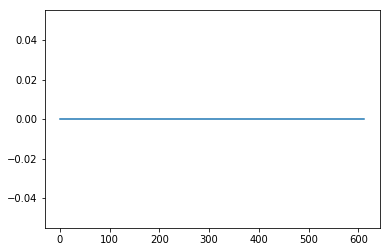

In [228]:
f0 = get_f0_amplitude(ave_amplitude)
plot_sound(f0)

#### 作用
* 能够计算出基频，能够用于区分清浊音
* 自相关系数在基频倍频处呈现突出的函数幅度值
* 计算量相对较小

#### 问题
* 计算基音周期时，不一定选择第一个峰值位置。

#### 发现
* 基音周期相对较高的帧确实对应着“有台词”的地方（测试音频基本都为浊音）

#### 个人理解
* 基音周期有高有低，表明原始音频中的浮渣性

### 倒谱特征